In [329]:
# Cálcula el porcentaje de error entre dos series de maáximos anuales.

import itertools

import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api       as     sm
import statsmodels.stats.api as     sms

In [330]:
# Archivo 1.
i = 0
# Archivo 2.
j = 2
# Cantidad de celdas a eliminar del borde.
k = 1

name = [ "CHIRPS_comp", "CHIRPS_megalopolis", "prec_hist_comp_CHIRPS",
    "prec_hist_comp_estaciones", "prec_hist_hist" ]

path_orig = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 
path_comp = "../results/" + name[j] + "/" + name[j] + "_tretorno.nc" 

ds_orig = xr.open_dataset(path_orig)
ds_comp = xr.open_dataset(path_comp)

if k != 0:
    ds_orig = ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp = ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

In [331]:
# Error total.
error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ))
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf("../results/comp_hist_CHIRPS.nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre CHIRPS_comp y prec_hist_comp_CHIRPS
count: 1071360.00
mean: 0.74
std: 0.57
min: -0.91
25%: 0.44
50%: 0.79
75%: 1.08
max: 8.51


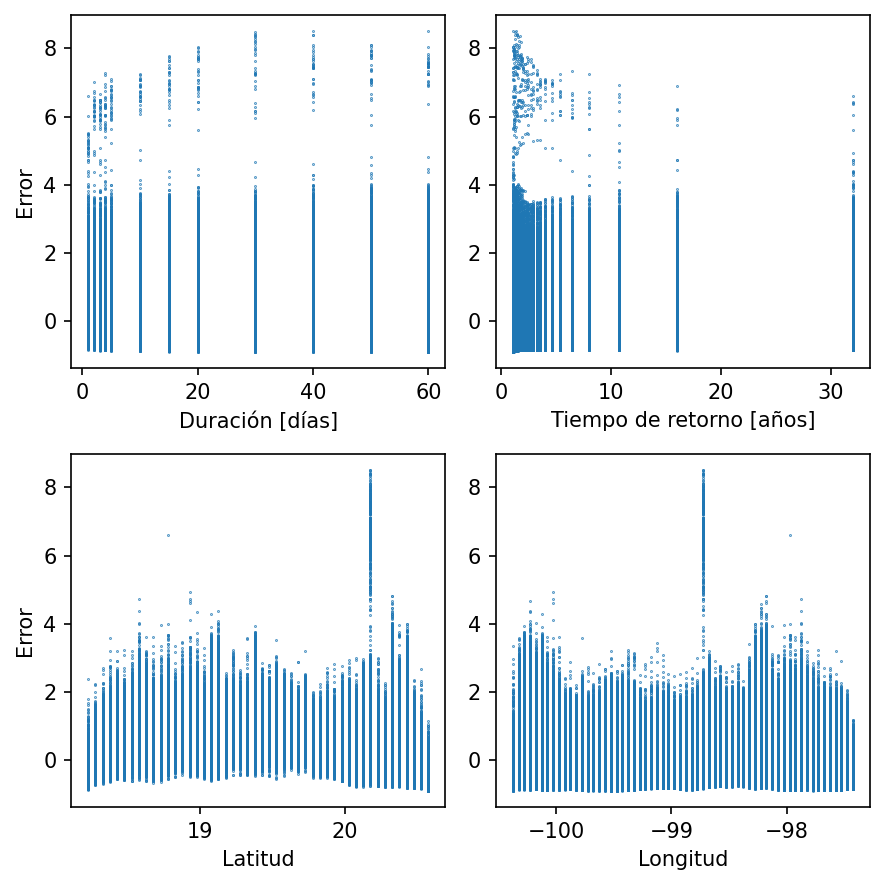

In [332]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

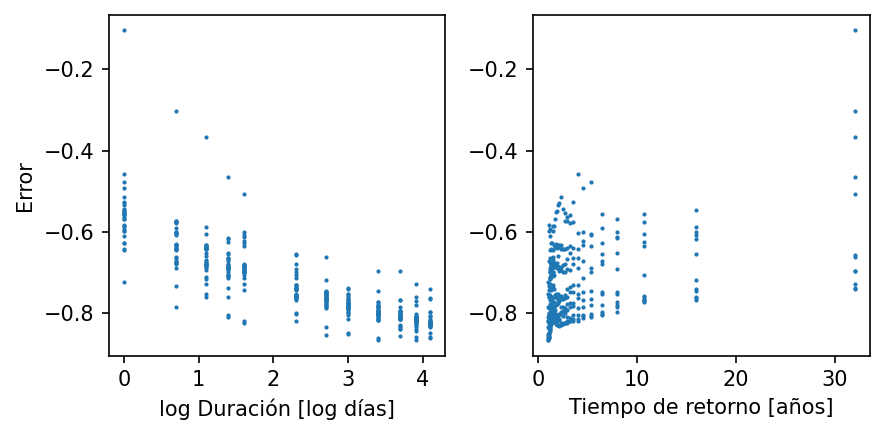

In [333]:
# Grafica de dispersión del error para una celda en particular.

import numpy as np

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 0
N = 0
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
ax[1].set_xlabel(f"Tiempo de retorno [años]")

fig.tight_layout()
plt.show()

In [334]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log( df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.log( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              #"DURACION",
                              #"TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              #"T_1",
                              "T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     1032.
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          7.34e-152
Time:                        17:59:24   Log-Likelihood:                 692.85
No. Observations:                 372   AIC:                            -1380.
Df Residuals:                     369   BIC:                            -1368.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6255      0.005   -136.660      0.000      -0.635      -0.617
D_1           -0.0619      0.002    -41.086      0.000      -0.065      -0.059
T_2            0.0452      0.002     19.396      0.000       0.041       0.050
==============================================================================
Omnibus:                      294.438   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11283.649
Skew:                           2.903   Prob(JB):                         0.00
Kurtosis:                      29.349   Cond. No.                         7.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [335]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST", "C_DURACION", "C_TRET", "P_CONST", "P_DURACION", "P_TRET",
         "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["DURACION"      ] = np.log( df_xs["DURACION"] )
        df_xs["TIEMPO_RETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ "DURACION", "TIEMPO_RETORNO" ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

# Guardamos el archivo.
df_s.to_xarray().to_netcdf("../results/Reglin_CHIRPS_comp.nc")

df_s.to_xarray()["ADJ_R_SQUARED"].mean()

<xarray.DataArray 'ADJ_R_SQUARED' ()>
array(0.46691427)

In [336]:
# Calcula la intensidad de precipitación corregida.

# Generamos las variables de manera matricial.
T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    (62 - k * 2, 50 - k * 2, 12, 31) )[:, :, :, 0:31]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    (62 - k * 2, 50 - k * 2, 31, 12) )[:, :, :, 0:12], 3, 2 ) 
B0 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["CONST"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )
B1 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_DURACION"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )
B2 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_TRET"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )

# Predicción.
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_comp.drop( ["AÑO"] ).copy()
ds_corr["INTENSIDAD"] = ( list( ds_orig.dims ),
    np.swapaxes( ds_corr["INTENSIDAD"].to_numpy(), 0, 1) / ( REG + 1 ) )

# Guardamos.
ds_corr.to_netcdf("../temp/prec_hist_hist_corr.nc")

In [347]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Int64Index([], dtype='int64', name='DURACION')


,,PROBABILIDAD
LATITUD,LONGITUD,


In [339]:
# Comparamos valores originales y corregidos.
ds_corr.to_dataframe()

INTENSIDAD  PROBABILIDAD
LATITUD   LONGITUD    DURACION TIEMPO_RETORNO                         
18.224998 -100.375008 1        1.032258        20.103831       0.96875
                               1.066667        30.689883       0.93750
                               1.103448        31.199929       0.90625
                               1.142857        32.147392       0.87500
                               1.185185        33.304201       0.84375
...                                                  ...           ...
20.574997 -97.425003  60       6.400000         8.268333       0.15625
                               8.000000         7.898815       0.12500
                               10.666667        7.699898       0.09375
                               16.000000        8.678263       0.06250
                               32.000000        8.259276       0.03125

[1071360 rows x 2 columns]

In [340]:
# Comparamos valores originales y corregidos.
ds_orig.to_dataframe()

AÑO  INTENSIDAD  PROBABILIDAD
LONGITUD    LATITUD   DURACION TIEMPO_RETORNO                                
-100.375008 18.224998 1        1.032258        2015   27.160156       0.96875
                               1.066667        1994   27.834961       0.93750
                               1.103448        2000   29.351562       0.90625
                               1.142857        2009   29.964844       0.87500
                               1.185185        2011   32.638672       0.84375
...                                             ...         ...           ...
-97.425003  20.574997 60       6.400000        2005   10.274283       0.15625
                               8.000000        2009   10.296159       0.12500
                               10.666667       1998   10.795215       0.09375
                               16.000000       2013   10.981413       0.06250
                               32.000000       1999   12.277116       0.03125

[1071360 rows x 3 columns]

In [341]:
# Error por tiempo de retorno.
tret            = df_e.groupby("TIEMPO_RETORNO").count(       )
tret.columns    = [ vars[0] ]
tret[ vars[1] ] = df_e.groupby("TIEMPO_RETORNO").mean(        )
tret[ vars[2] ] = df_e.groupby("TIEMPO_RETORNO").std(         )
tret[ vars[3] ] = df_e.groupby("TIEMPO_RETORNO").min(         )
tret[ vars[4] ] = df_e.groupby("TIEMPO_RETORNO").quantile(0.25)
tret[ vars[5] ] = df_e.groupby("TIEMPO_RETORNO").quantile(0.5 )
tret[ vars[6] ] = df_e.groupby("TIEMPO_RETORNO").quantile(0.75)
tret[ vars[7] ] = df_e.groupby("TIEMPO_RETORNO").max(         )

tret.describe()

,count,mean,std,min,25%,50%,75%,max
count,31.0,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,34560.0,0.740788,0.572402,-0.865670,0.435187,0.785804,1.082268,7.745401
std,0.0,0.008500,0.023290,0.016760,0.022157,0.015150,0.011189,0.555239
min,34560.0,0.713602,0.553705,-0.910922,0.366060,0.734459,1.071864,6.604713
25%,34560.0,0.740631,0.555996,-0.869314,0.433238,0.781135,1.074387,7.299136
50%,34560.0,0.742382,0.565652,-0.857161,0.440420,0.789658,1.081650,7.726913
75%,34560.0,0.743403,0.577886,-0.854547,0.449777,0.796662,1.085745,8.240811
max,34560.0,0.760389,0.648011,-0.847261,0.452467,0.800600,1.130484,8.510044


In [342]:
# Error por duración.
duracion            = df_e.groupby("DURACION").count(       )
duracion.columns    = [ vars[0] ]
duracion[ vars[1] ] = df_e.groupby("DURACION").mean(        )
duracion[ vars[2] ] = df_e.groupby("DURACION").std(         )
duracion[ vars[3] ] = df_e.groupby("DURACION").min(         )
duracion[ vars[4] ] = df_e.groupby("DURACION").quantile(0.25)
duracion[ vars[5] ] = df_e.groupby("DURACION").quantile(0.5 )
duracion[ vars[6] ] = df_e.groupby("DURACION").quantile(0.75)
duracion[ vars[7] ] = df_e.groupby("DURACION").max(         )

duracion.describe()

,count,mean,std,min,25%,50%,75%,max
count,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,89280.0,0.740788,0.570883,-0.884568,0.436163,0.785031,1.081181,7.610951
std,0.0,0.037238,0.033910,0.023952,0.054282,0.026157,0.018189,0.714004
min,89280.0,0.692856,0.526211,-0.910922,0.361255,0.751938,1.060991,6.604713
25%,89280.0,0.704028,0.540200,-0.905280,0.384274,0.759937,1.064683,7.074874
50%,89280.0,0.745529,0.574281,-0.886166,0.445733,0.781456,1.076230,7.520667
75%,89280.0,0.778338,0.600141,-0.869561,0.493049,0.809381,1.095684,8.203571
max,89280.0,0.786361,0.617734,-0.838669,0.499228,0.821011,1.108274,8.510044


In [343]:
# Error por latitud.
latitud            = df_e.groupby("LATITUD").count(       )
latitud.columns    = [ vars[0] ]
latitud[ vars[1] ] = df_e.groupby("LATITUD").mean(        )
latitud[ vars[2] ] = df_e.groupby("LATITUD").std(         )
latitud[ vars[3] ] = df_e.groupby("LATITUD").min(         )
latitud[ vars[4] ] = df_e.groupby("LATITUD").quantile(0.25)
latitud[ vars[5] ] = df_e.groupby("LATITUD").quantile(0.5 )
latitud[ vars[6] ] = df_e.groupby("LATITUD").quantile(0.75)
latitud[ vars[7] ] = df_e.groupby("LATITUD").max(         )

latitud.describe()

,count,mean,std,min,25%,50%,75%,max
count,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,22320.0,0.740788,0.457132,-0.606601,0.459376,0.739131,1.007859,3.364585
std,0.0,0.331844,0.108107,0.149311,0.318194,0.334145,0.357451,1.188766
min,22320.0,-0.634794,0.204230,-0.910922,-0.775704,-0.681970,-0.559764,1.148498
25%,22320.0,0.672256,0.405927,-0.742576,0.367760,0.691784,0.965588,2.687102
50%,22320.0,0.831464,0.444550,-0.575945,0.570000,0.838116,1.081518,3.193672
75%,22320.0,0.931766,0.482977,-0.486776,0.644370,0.920743,1.201811,3.681841
max,22320.0,1.029249,0.939326,-0.301426,0.752447,1.004645,1.318062,8.510044


In [344]:
# Error por longitud.
longitud            = df_e.groupby("LONGITUD").count(       )
longitud.columns    = [ vars[0] ]
longitud[ vars[1] ] = df_e.groupby("LONGITUD").mean(        )
longitud[ vars[2] ] = df_e.groupby("LONGITUD").std(         )
longitud[ vars[3] ] = df_e.groupby("LONGITUD").min(         )
longitud[ vars[4] ] = df_e.groupby("LONGITUD").quantile(0.25)
longitud[ vars[5] ] = df_e.groupby("LONGITUD").quantile(0.5 )
longitud[ vars[6] ] = df_e.groupby("LONGITUD").quantile(0.75)
longitud[ vars[7] ] = df_e.groupby("LONGITUD").max(         )

latitud.describe()

,count,mean,std,min,25%,50%,75%,max
count,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,22320.0,0.740788,0.457132,-0.606601,0.459376,0.739131,1.007859,3.364585
std,0.0,0.331844,0.108107,0.149311,0.318194,0.334145,0.357451,1.188766
min,22320.0,-0.634794,0.204230,-0.910922,-0.775704,-0.681970,-0.559764,1.148498
25%,22320.0,0.672256,0.405927,-0.742576,0.367760,0.691784,0.965588,2.687102
50%,22320.0,0.831464,0.444550,-0.575945,0.570000,0.838116,1.081518,3.193672
75%,22320.0,0.931766,0.482977,-0.486776,0.644370,0.920743,1.201811,3.681841
max,22320.0,1.029249,0.939326,-0.301426,0.752447,1.004645,1.318062,8.510044


In [345]:
# Dsitribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf("../results/comp_hist_CHIRPS_espacial.nc")

desc = latitud.describe().copy()

for v in vars:
    desc[ v ] = [ espacial[ v ].count(       ).values + 0,
                  espacial[ v ].mean(        ).values + 0,
                  espacial[ v ].std(         ).values + 0,
                  espacial[ v ].min(         ).values + 0,
                  espacial[ v ].quantile(0.25).values + 0,
                  espacial[ v ].quantile(0.5 ).values + 0,
                  espacial[ v ].quantile(0.75).values + 0,
                  espacial[ v ].max(         ).values + 0 ]

desc

,count,mean,std,min,25%,50%,75%,max
count,2880.0,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000
mean,372.0,0.740788,0.179526,0.235354,0.622881,0.732485,0.854383,1.414861
std,0.0,0.539656,0.069073,0.449386,0.533936,0.549892,0.557194,0.723555
min,372.0,-0.781300,0.048410,-0.910922,-0.839331,-0.794817,-0.734297,-0.587031
25%,372.0,0.467887,0.131808,-0.034421,0.349861,0.455701,0.575282,1.014475
50%,372.0,0.793691,0.164824,0.287669,0.701014,0.797230,0.895658,1.382771
75%,372.0,1.076238,0.213134,0.534170,0.955247,1.070656,1.191390,1.784066
max,372.0,6.612451,1.035886,2.444550,6.060491,6.679532,7.392852,8.510044
